# IMPORTATION

In [1]:
import csv
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport #https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html
#import qgrid

import pingouin as pg
import scipy
from pca import pca #pip install pca https://github.com/erdogant/pca

import ast #Tranfromer un dictioner

/home/chispitas/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost #pip install xgboost

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib
from scipy.stats import randint
import shap #https://shap.readthedocs.io/en/latest/index.html

2021-12-03 12:19:08.311073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 12:19:08.311114: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
dirDATA = '/media/chispitas/DATOS/Documento/Estudios/DataScientist/Projecto/P4-Anticipez les besoins en consommation electrique de batiments/Code/'
direc0 = '/media/chispitas/DATOS/Documento/Estudios/DataScientist/Projecto/P4-Anticipez les besoins en consommation electrique de batiments/Code/Data/'

str_dfML = direc0 + 'dfML.csv'

In [6]:
#dfDATA_Original_15 = pd.read_csv(dir_15, encoding='utf-8', nrows = 10) #, delimiter='\t'
dfML = pd.read_csv(str_dfML, encoding='utf-8') #, delimiter='\t'
dfML = dfML.convert_dtypes()
#dfML = dfML.set_index('OSEBuildingID')
dfML = dfML.sort_values(['GHGEmissions(MetricTonsCO2e)'], ascending = True)
dfML.dtypes

OSEBuildingID                     Int64
SiteEnergyUse(kBtu)             Float64
GHGEmissions(MetricTonsCO2e)    Float64
PropertyGFABuilding(s)            Int64
NumberofFloors                    Int64
PrimaryPropertyType              string
Neighborhood                     string
YearBuilt_10y                     Int64
ENERGYSTARScore                   Int64
dtype: object

In [7]:
dfDESCRIPTION = dfML.describe(include='all')
LEN = len(dfML)
dfTAUX = dfDESCRIPTION.T

dfTAUX['%full'] = (dfTAUX['count']/LEN)*100
dfTAUX['%unique'] = (1-dfTAUX['unique']/dfTAUX['count'])*100
dfTAUX.drop(['top'], axis=1,inplace = True)
dfTAUX.sort_values('%full', ascending = False ,inplace = True)
dfTAUX[['count', 'unique', 'freq', 'mean', 'std', 'min', '25%', '50%','75%', 'max', '%full', '%unique']].style.format('{0:,.1f}').background_gradient(subset=['count', 'unique', 'freq', 'mean', 'std', 'min', '25%', '50%','75%', 'max', '%full', '%unique'])

,count,unique,freq,mean,std,min,25%,50%,75%,max,%full,%unique
OSEBuildingID,"1,956.0",nan,nan,"20,407.1","12,002.4",1.0,"19,877.2","22,776.5","25,748.8","50,059.0",100.0,nan
SiteEnergyUse(kBtu),"1,956.0",nan,nan,"5,123,266.1","11,172,804.2","79,711.8","1,106,117.6","2,052,408.8","4,830,159.4","274,682,200.0",100.0,nan
GHGEmissions(MetricTonsCO2e),"1,956.0",nan,nan,107.1,253.1,0.9,15.5,44.1,103.2,"6,330.9",100.0,nan
PropertyGFABuilding(s),"1,956.0",nan,nan,"93,297.3","137,734.3","3,636.0","29,801.2","48,552.5","96,047.5","1,632,820.0",100.0,nan
NumberofFloors,"1,956.0",nan,nan,6.5,6.7,1.0,4.0,5.0,7.0,100.0,100.0,nan
PrimaryPropertyType,"1,956.0",23.0,587.0,nan,nan,nan,nan,nan,nan,nan,100.0,98.8
Neighborhood,"1,956.0",13.0,366.0,nan,nan,nan,nan,nan,nan,nan,100.0,99.3
YearBuilt_10y,"1,956.0",nan,nan,"1,963.8",33.1,"1,900.0","1,940.0","1,970.0","1,990.0","2,010.0",100.0,nan
ENERGYSTARScore,"1,956.0",nan,nan,66.2,27.4,1.0,49.8,73.0,89.0,100.0,100.0,nan


## STYLE Graph

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) #Montrer toutes les colonnes

#using the style 
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-notebook') 
plt.style.use('seaborn-poster') 
plt.rcParams["figure.figsize"] = [6, 5]

#Width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

#Legend
plt.rcParams['legend.loc'] = 'center left'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams['legend.markerscale'] = 3

#Scatter marker
plt.rcParams['scatter.marker'] = '.'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

## Separation des variables

In [10]:
# Organisation des variables (NUM/STR,DISCRETES/CONTINUES)
def lVAR_classification(dfSET):
 
    lVAR_cible = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'] #Variable CIBLES 

    lVAR_str = dfSET.select_dtypes(exclude=[np.number]).columns.difference(lVAR_cible)  #Les variables str DISCRETES ET CONTINUES
    lVAR_num = dfSET.select_dtypes(include=[np.number]).columns.difference(lVAR_cible)  #Les variables floats DISCRETES ET CONTINUES

    lVAR_str_discret = dfSET[lVAR_str].nunique().sort_values()[(dfSET.nunique()<1000)].index.difference(['Comment']) #Les variables str DISCRETES
    lVAR_str_continue  = lVAR_str.difference(lVAR_str_discret) #Les variables floats CONTINUES

    lVAR_num_discret = dfSET[lVAR_num].nunique().sort_values()[(dfSET.nunique()<1000)].index.difference(['SiteEnergyUse(kBtu)_predicted', 'NumberofFloors','OtherFuelUse(kBtu)', 'SPD Beats', 'SteamUse(kBtu)', 'GHGEmissionsIntensity', 'GHGEmissionsIntensity(kgCO2e/ft2)']) #Les variables floats DISCRETES
    lVAR_num_continue = lVAR_num.difference(lVAR_num_discret) #Les variables floats CONTINUES

    lVAR_discret = np.concatenate((lVAR_str_discret, lVAR_num_discret), axis=None)
    lVAR_continue = np.concatenate((lVAR_str_continue, lVAR_num_continue), axis=None)

    print('lVAR_cible',lVAR_cible)

    print('lVAR_str_continue ',lVAR_str_continue)

    print('lVAR_num_discret ',lVAR_num_discret)
    print('lVAR_num_continue ',lVAR_num_continue)

    print('lVAR_discret ',lVAR_discret)
    print('lVAR_continue ',lVAR_continue)
    
    return lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue

In [11]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['ENERGYSTARScore', 'YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['NumberofFloors', 'OSEBuildingID', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'ENERGYSTARScore' 'YearBuilt_10y']
lVAR_continue  ['NumberofFloors' 'OSEBuildingID' 'PropertyGFABuilding(s)']


# Model selection

## Training and Test Set split

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(dfML[dfML.columns.difference(lVAR_cible)], dfML['GHGEmissions(MetricTonsCO2e)'], test_size=0.2, random_state=0)

Xtrain

,ENERGYSTARScore,Neighborhood,NumberofFloors,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),YearBuilt_10y
194,71,lake union,6,475,large office,353919,2000
544,88,northwest,3,20130,worship facility,23931,1910
1932,35,northeast,3,49939,low-rise multifamily,31928,2010
1491,51,east,17,25965,senior care community,153312,1960
763,76,east,6,21349,mid-rise multifamily,42331,1980
...,...,...,...,...,...,...,...
291,91,east,5,649,small- and mid-sized office,76624,1930
1721,92,magnolia / queen anne,4,27569,low-rise multifamily,97855,2000
446,69,downtown,3,19696,retail store,147545,1910
279,15,greater duwamish,7,628,distribution center,64800,1910


In [13]:
Xtrain_num = Xtrain[set(lVAR_num_continue).difference([''])].copy()
Xtrain_cat = Xtrain[lVAR_discret].copy()

Xtest_num = Xtest[set(lVAR_num_continue).difference([''])].copy()
Xtest_cat = Xtest[lVAR_discret].copy()

Xtest_num

,PropertyGFABuilding(s),OSEBuildingID,NumberofFloors
1389,53919,25240,5
1852,26263,42069,2
1037,36837,23212,5
1025,68669,23162,7
1271,48020,24538,2
...,...,...,...
21,54986,50,3
613,52166,20512,4
428,169149,19601,7
1292,24090,24631,5


In [14]:
Xtrain_cat

,Neighborhood,PrimaryPropertyType,ENERGYSTARScore,YearBuilt_10y
194,lake union,large office,71,2000
544,northwest,worship facility,88,1910
1932,northeast,low-rise multifamily,35,2010
1491,east,senior care community,51,1960
763,east,mid-rise multifamily,76,1980
...,...,...,...,...
291,east,small- and mid-sized office,91,1930
1721,magnolia / queen anne,low-rise multifamily,92,2000
446,downtown,retail store,69,1910
279,greater duwamish,distribution center,15,1910


## Encoding categorical attribute

In [15]:
#DF Encoding
Xtest_cat_encoded = pd.DataFrame([], index=Xtest.index)
Xtrain_cat_encoded = pd.DataFrame([], index=Xtrain.index)

#ylog
Xtest_cat_encoded_ylog = pd.DataFrame([], index=Xtest.index)
Xtrain_cat_encoded_ylog = pd.DataFrame([], index=Xtrain.index)

In [16]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['ENERGYSTARScore', 'YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['NumberofFloors', 'OSEBuildingID', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'ENERGYSTARScore' 'YearBuilt_10y']
lVAR_continue  ['NumberofFloors' 'OSEBuildingID' 'PropertyGFABuilding(s)']


### TargetEncoder

In [17]:
def TargetEncode(X, y): # Xtrain_cat[iVAR], ytrain
    TE=pd.concat([X,y],axis=1)
    TE= TE.groupby(X.name).mean()
    property_map = TE.to_dict()
    return X.map(lambda x: property_map[y.name][x])

In [18]:
for iVAR in ['PrimaryPropertyType', 'Neighborhood']:
    Xtrain_cat_encoded[iVAR] = TargetEncode(Xtrain_cat[iVAR], ytrain)
    Xtest_cat_encoded[iVAR] = TargetEncode(Xtest_cat[iVAR], ytest)
    
    #ylog
    Xtrain_cat_encoded_ylog[iVAR] = TargetEncode(Xtrain_cat[iVAR], np.log(ytrain))
    Xtest_cat_encoded_ylog[iVAR] = TargetEncode(Xtest_cat[iVAR], np.log(ytest))

Xtrain_cat_encoded_ylog

,PrimaryPropertyType,Neighborhood
194,4.930853,3.730640
544,3.479559,3.502758
1932,2.923518,3.372690
1491,5.148003,3.792350
763,3.746776,3.792350
...,...,...
291,3.335940,3.792350
1721,2.923518,3.449921
446,4.063880,4.555799
279,3.429573,3.545522


In [19]:
Xtrain_cat_encoded

,PrimaryPropertyType,Neighborhood
194,208.867710,90.777426
544,45.342391,95.922258
1932,32.944270,73.832931
1491,305.914571,110.371962
763,72.651394,110.371962
...,...,...
291,43.419217,110.371962
1721,32.944270,64.530262
446,118.006379,200.695338
279,52.393929,63.772013


### OrdinalEncoder

In [20]:
from sklearn.preprocessing import OrdinalEncoder
#for iVAR in ['YearBuilt_10y', 'NumberofFloors', 'ENERGYSTARScore'] :
for iVAR in ['YearBuilt_10y', 'ENERGYSTARScore'] :
    enc = OrdinalEncoder().fit(Xtrain_cat[[iVAR]])
    Xtrain_cat_encoded[iVAR] = enc.transform(Xtrain_cat[[iVAR]])
    Xtest_cat_encoded[iVAR] = enc.transform(Xtest_cat[[iVAR]])
    
    #ylog
    Xtrain_cat_encoded_ylog[iVAR] = Xtrain_cat_encoded[iVAR]
    Xtest_cat_encoded_ylog[iVAR] = Xtest_cat_encoded[iVAR]

Xtrain_cat_encoded_ylog

,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,4.930853,3.730640,10.0,70.0
544,3.479559,3.502758,1.0,87.0
1932,2.923518,3.372690,11.0,34.0
1491,5.148003,3.792350,6.0,50.0
763,3.746776,3.792350,8.0,75.0
...,...,...,...,...
291,3.335940,3.792350,3.0,90.0
1721,2.923518,3.449921,10.0,91.0
446,4.063880,4.555799,1.0,68.0
279,3.429573,3.545522,1.0,14.0


In [21]:
Xtrain_cat_encoded

,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,208.867710,90.777426,10.0,70.0
544,45.342391,95.922258,1.0,87.0
1932,32.944270,73.832931,11.0,34.0
1491,305.914571,110.371962,6.0,50.0
763,72.651394,110.371962,8.0,75.0
...,...,...,...,...
291,43.419217,110.371962,3.0,90.0
1721,32.944270,64.530262,10.0,91.0
446,118.006379,200.695338,1.0,68.0
279,52.393929,63.772013,1.0,14.0


## Scaling

In [22]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['ENERGYSTARScore', 'YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['NumberofFloors', 'OSEBuildingID', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'ENERGYSTARScore' 'YearBuilt_10y']
lVAR_continue  ['NumberofFloors' 'OSEBuildingID' 'PropertyGFABuilding(s)']


In [23]:
Xtrain_S_E = pd.concat([Xtrain_num, Xtrain_cat_encoded], axis=1)
Xtest_S_E = pd.concat([Xtest_num, Xtest_cat_encoded], axis=1)

#ylog
Xtrain_S_E_ylog = pd.concat([Xtrain_num, Xtrain_cat_encoded_ylog], axis=1)
Xtest_S_E_ylog = pd.concat([Xtest_num, Xtest_cat_encoded_ylog], axis=1)

Xtrain_S_E_ylog

,PropertyGFABuilding(s),OSEBuildingID,NumberofFloors,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,353919,475,6,4.930853,3.730640,10.0,70.0
544,23931,20130,3,3.479559,3.502758,1.0,87.0
1932,31928,49939,3,2.923518,3.372690,11.0,34.0
1491,153312,25965,17,5.148003,3.792350,6.0,50.0
763,42331,21349,6,3.746776,3.792350,8.0,75.0
...,...,...,...,...,...,...,...
291,76624,649,5,3.335940,3.792350,3.0,90.0
1721,97855,27569,4,2.923518,3.449921,10.0,91.0
446,147545,19696,3,4.063880,4.555799,1.0,68.0
279,64800,628,7,3.429573,3.545522,1.0,14.0


In [24]:
Xtrain_S_E

,PropertyGFABuilding(s),OSEBuildingID,NumberofFloors,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,353919,475,6,208.867710,90.777426,10.0,70.0
544,23931,20130,3,45.342391,95.922258,1.0,87.0
1932,31928,49939,3,32.944270,73.832931,11.0,34.0
1491,153312,25965,17,305.914571,110.371962,6.0,50.0
763,42331,21349,6,72.651394,110.371962,8.0,75.0
...,...,...,...,...,...,...,...
291,76624,649,5,43.419217,110.371962,3.0,90.0
1721,97855,27569,4,32.944270,64.530262,10.0,91.0
446,147545,19696,3,118.006379,200.695338,1.0,68.0
279,64800,628,7,52.393929,63.772013,1.0,14.0


In [25]:
from sklearn.preprocessing import StandardScaler
for iVAR in Xtrain_S_E.columns :
    scal = StandardScaler().fit(Xtrain_S_E[[iVAR]])
    Xtrain_S_E[iVAR] = scal.transform(Xtrain_S_E[[iVAR]])
    Xtest_S_E[iVAR] = scal.transform(Xtest_S_E[[iVAR]])
    Xtrain_S_E_ylog[iVAR] = scal.transform(Xtrain_S_E_ylog[[iVAR]])
    Xtest_S_E_ylog[iVAR] = scal.transform(Xtest_S_E_ylog[[iVAR]])

Xtrain_S_E_ylog

,PropertyGFABuilding(s),OSEBuildingID,NumberofFloors,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,1.832657,-1.645554,-0.082844,-0.979972,-2.026196,1.099820,0.149327
544,-0.501214,-0.014924,-0.511877,-0.994318,-2.030797,-1.607133,0.771926
1932,-0.444655,2.458109,-0.511877,-0.999815,-2.033424,1.400592,-1.169117
1491,0.413845,0.469163,1.490277,-0.977826,-2.024950,-0.103270,-0.583142
763,-0.371078,0.086208,-0.082844,-0.991677,-2.024950,0.498275,0.332444
...,...,...,...,...,...,...,...
291,-0.128538,-1.631118,-0.225855,-0.995738,-2.024950,-1.005588,0.881796
1721,0.021620,0.602235,-0.368866,-0.999815,-2.031864,1.099820,0.918419
446,0.373058,-0.050929,-0.511877,-0.988542,-2.009533,-1.607133,0.076080
279,-0.212164,-1.632861,0.060167,-0.994812,-2.029934,-1.607133,-1.901585


In [26]:
Xtrain_S_E

,PropertyGFABuilding(s),OSEBuildingID,NumberofFloors,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore
194,1.832657,-1.645554,-0.082844,1.035916,-0.268415,1.099820,0.149327
544,-0.501214,-0.014924,-0.511877,-0.580510,-0.164522,-1.607133,0.771926
1932,-0.444655,2.458109,-0.511877,-0.703064,-0.610584,1.400592,-1.169117
1491,0.413845,0.469163,1.490277,1.995211,0.127268,-0.103270,-0.583142
763,-0.371078,0.086208,-0.082844,-0.310564,0.127268,0.498275,0.332444
...,...,...,...,...,...,...,...
291,-0.128538,-1.631118,-0.225855,-0.599520,0.127268,-1.005588,0.881796
1721,0.021620,0.602235,-0.368866,-0.703064,-0.798437,1.099820,0.918419
446,0.373058,-0.050929,-0.511877,0.137764,1.951215,-1.607133,0.076080
279,-0.212164,-1.632861,0.060167,-0.510806,-0.813749,-1.607133,-1.901585


## RandomizedSearchCV

### Parameters

In [27]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain)
y_test = np.log(ytest)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

In [28]:
from scipy.stats import randint
from scipy.stats import uniform
param_Ridge = [{'alpha': uniform(0.01, 150)}]
param_Lasso = [{'alpha': uniform(0.01, 150)}]
param_ElasticNet = [{'alpha': uniform(0.01, 150), 'l1_ratio': uniform(0.25, 0.75)}]

param_RandomForestRegressor = [{'max_features': randint(low=2, high=5), 'max_leaf_nodes':randint(low=2, high=80),
                                'n_estimators': randint(low=1, high=250)}]

param_XGBRegressor = [{'alpha': uniform(0.01, 50), "colsample_bytree":uniform(0, 1), 'max_depth': randint(low=1, high=6), 
                       "min_child_weight":uniform(0, 1.5), 'n_estimators': randint(low=1, high=250)}]

param_rnd = [param_Ridge, param_Lasso, param_ElasticNet, param_RandomForestRegressor, param_XGBRegressor]

model_names_rnd = ['Ridge_rnd', 'Lasso_rnd', 'ElasticNet_rnd', 'RandomForestRegressor_rnd', 'XGBRegressor_rnd']

models_rnd = ['Ridge()', 'Lasso()', 'ElasticNet()', 'RandomForestRegressor(random_state=42, bootstrap=[False])', 'xgboost.XGBRegressor(objective ="reg:linear")']

### For

from sklearn.model_selection import RandomizedSearchCV
import joblib

results = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in set(models_rnd).difference([]):
    c = models_rnd.index(iMODEL) #Parametres of model
    
    print(iMODEL)
    search = RandomizedSearchCV(estimator=eval(iMODEL), param_distributions=param_rnd[c], n_iter=100, cv=4, 
                                #n_iter=10, cv=4, scoring='neg_mean_squared_error', random_state=42, n_jobs=6)    
                                scoring=['neg_mean_squared_error','r2'], refit='r2',
                                random_state=42, n_jobs=6)    
    
    search = search.fit(X_train, y_train)
    
    joblib.dump(search,dirDATA + model_names_rnd[c]+'_CO2_Multi.pkl')

### Results

In [29]:
dfALL_rnd = pd.DataFrame([])
dfTOP_rnd = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in models_rnd:
    c = models_rnd.index(iMODEL) #Parametres of model
    
    search = joblib.load(dirDATA + model_names_rnd[c]+'_CO2_Multi.pkl') #Import restulats calcule
    
    al = pd.DataFrame(search.cv_results_)
    #al['RMSE'] =  np.sqrt(-al['mean_test_score'])
    #al['std_RMSE'] =  np.sqrt(al['std_test_score'])
    al["params"] = al["params"].astype('str').convert_dtypes()
    al = al.sort_values(['rank_test_r2'], ascending = True)    #r = pd.DataFrame(search.cv_results_)

    al = pd.concat([al], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfALL_rnd = pd.concat([dfALL_rnd,al], axis = 0)

    t = al.iloc[:3]
    #tt = pd.concat([t], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfTOP_rnd = pd.concat([dfTOP_rnd,t], axis = 0)

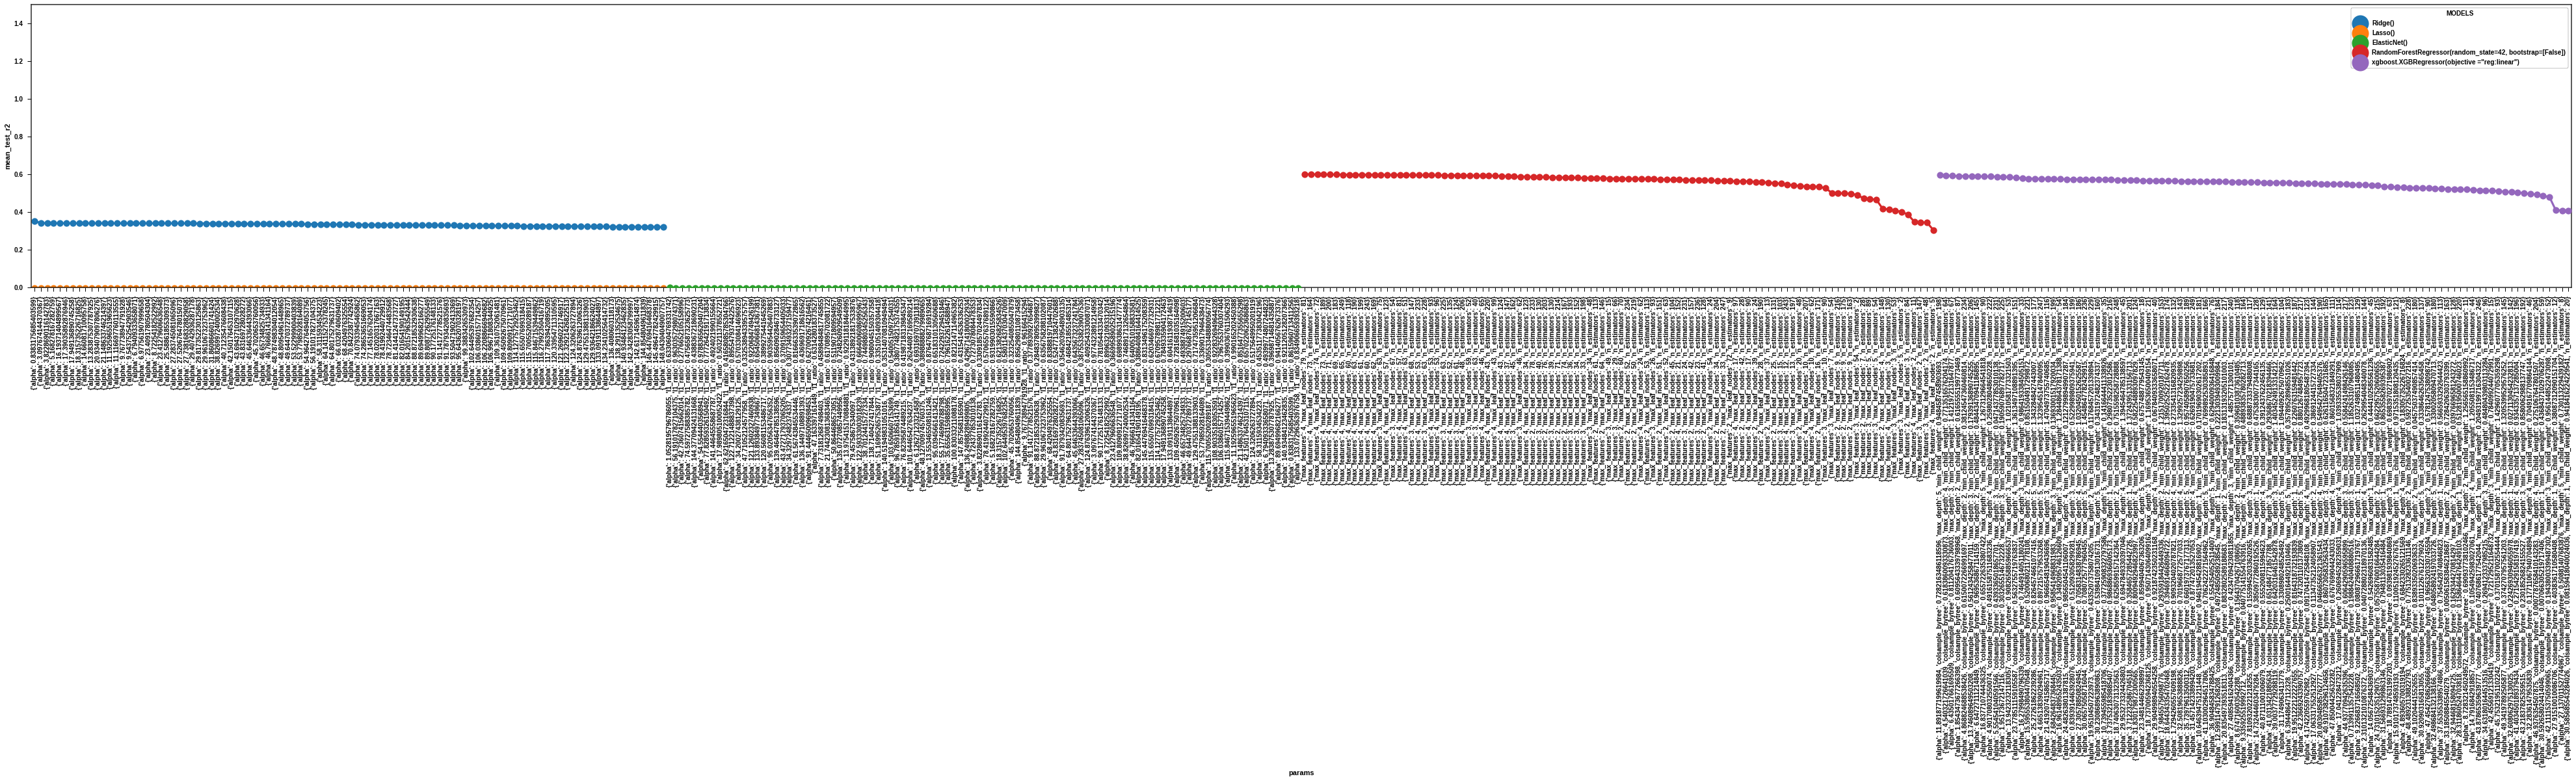

In [30]:
plt.style.use('seaborn-notebook') 
plt.rcParams["figure.figsize"] = [10*7,8]

al = dfALL_rnd.copy().reset_index()
fig, g = plt.subplots()

g = sns.pointplot(data=al, x="params", y="mean_test_r2", hue="MODELS", ci="roc_auc", capsize=.2)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylim=(0,1.5))
#ax.set(xlim=(0,2*10**6))
fig.savefig(direc0 + '34-dfALL_rnd_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

In [31]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_rnd[['params']+c].style.background_gradient(subset=c)

In [32]:
c = ['mean_test_r2',  'mean_test_neg_mean_squared_error']

dfTOP_rnd[['params']+c].style.background_gradient(subset=c)

### Bests models

In [33]:
search.best_estimator_

XGBRegressor(alpha=11.891877199619984, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7282163486118596, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=0.9484587458903693, missing=nan,
             monotone_constraints='()', n_estimators=198, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=11.8918772, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [34]:
BEST_values = pd.DataFrame([np.float64(y_train)], index=['TRAIN']).T

for iMODEL in models_rnd:
    c = models_rnd.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_rnd[c]+'_CO2_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_train, y_train)
    predictions = search.best_estimator_.predict(X_train)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_train), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_train), np.array(predictions))
    lin_r2 = r2_score(np.array(y_train), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    print('Mean:','%0.0f'%(y_train.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_train.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
Mean: 4 / MSE: 1.19 / RMSE: 1.09 / MAE: 0.90 / r2: 0.34 / RelativeError(%): 29.2 %
Lasso()
Mean: 4 / MSE: 1.81 / RMSE: 1.34 / MAE: 1.09 / r2: 0.00 / RelativeError(%): 35.9 %
ElasticNet()
Mean: 4 / MSE: 1.80 / RMSE: 1.34 / MAE: 1.09 / r2: 0.00 / RelativeError(%): 35.8 %
RandomForestRegressor(random_state=42, bootstrap=[False])
Mean: 4 / MSE: 0.42 / RMSE: 0.64 / MAE: 0.53 / r2: 0.77 / RelativeError(%): 17.2 %
xgboost.XGBRegressor(objective ="reg:linear")
[12:20:05] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 4 / MSE: 0.48 / RMSE: 0.69 / MAE: 0.55 / r2: 0.74 / RelativeError(%): 18.5 %


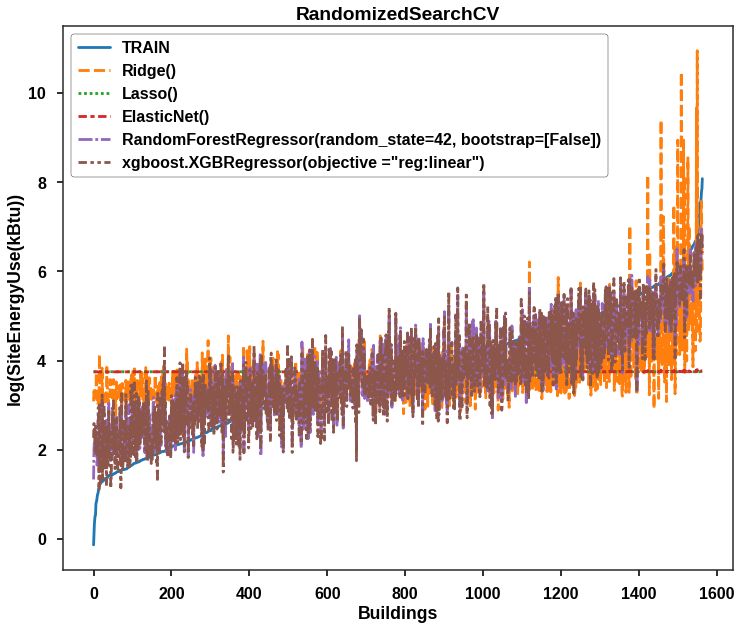

In [35]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TRAIN'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_rnd_values_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

### Features contribution

In [36]:
search = joblib.load(dirDATA + model_names_rnd[4]+'_CO2_Multi.pkl')
final_model = search.best_estimator_
final_model

XGBRegressor(alpha=11.891877199619984, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7282163486118596, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=0.9484587458903693, missing=nan,
             monotone_constraints='()', n_estimators=198, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=11.8918772, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

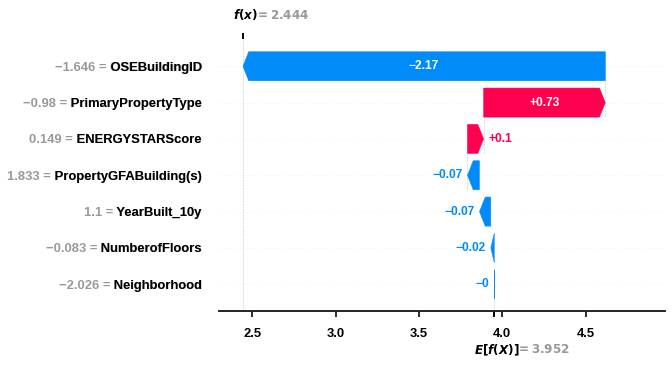

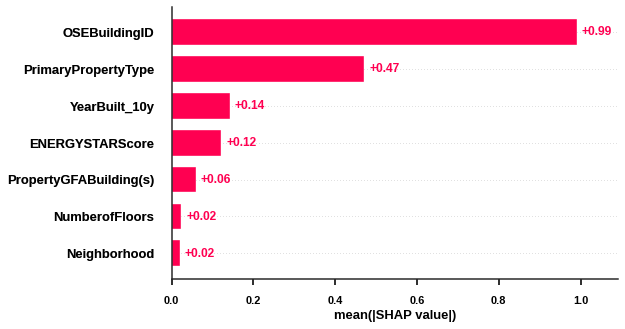

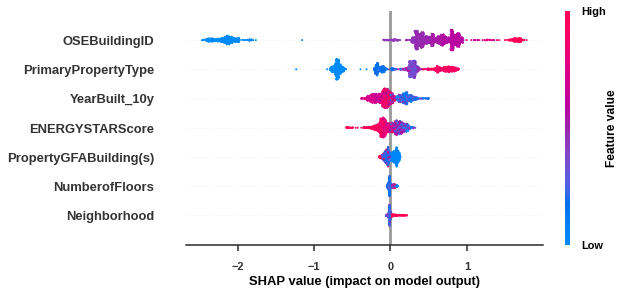

In [37]:
#vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Fine-tune the model

## GridSearchCV

### Parameters

In [38]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain)
y_test = np.log(ytest)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

In [39]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [40]:
#TEST
np.int64(np.geomspace(50, 200, num=5).round(0))
np.geomspace(0.1, 50, num=8)

array([ 0.1       ,  0.24297811,  0.5903836 ,  1.4345029 ,  3.48552798,
        8.4690699 , 20.57798569, 50.        ])

In [41]:
param_Ridge = [{'alpha': np.geomspace(0.1, 100, num=20)}]
#param_Lasso = [{'alpha': np.geomspace(0.1, 50, num=8)}]
#param_ElasticNet = [{'alpha': np.geomspace(0.1, 50, num=8), 'l1_ratio': [0.25, 0.5, 0.75]}]
d_Ridge = 20
print('combinations Ridge: ', d_Ridge)

param_RandomForestRegressor = [{'max_leaf_nodes':np.int64(np.linspace(20, 100, 6).round(0)),
                                'n_estimators': np.int64(np.geomspace(150, 200, num=3).round(0))}]
print('combinations param_RandomForestRegressor: ', 6*3)

param_XGBRegressor = [{'alpha': np.geomspace(0.01, 10, num=10), "colsample_bytree":np.linspace(0.5, 1, 2), 
                       'max_depth': [3,4], "min_child_weight":np.linspace(0.5, 1.5,2), 
                       'n_estimators': np.int64(np.geomspace(50, 150, num=3).round(0))}]
print('combinations param_RandomForestRegressor: ', 10*3*2*2*3)

param_Grid = [param_Ridge, param_RandomForestRegressor, param_XGBRegressor]

model_names_Grid = ['Ridge_Grid', 'RandomForestRegressor_Grid', 'XGBRegressor_Grid']

models_Grid = ['Ridge()', 'RandomForestRegressor()', 
               'xgboost.XGBRegressor(objective ="reg:linear")']

combinations Ridge:  20
combinations param_RandomForestRegressor:  18
combinations param_RandomForestRegressor:  360


### For

In [42]:
models_Grid.index('RandomForestRegressor()')

1

results_Grid = pd.DataFrame([])

#for iMODEL_Grid in models_Grid:
for iMODEL_Grid in set(models_Grid).difference([]):
    c = models_Grid.index(iMODEL_Grid)
    
    print(iMODEL_Grid)
    #search_Grid = GridSearchCV(estimator=eval(iMODEL_Grid), param_grid=param_Grid[c], cv=10, scoring='neg_mean_squared_error', n_jobs=-1)    
    search_Grid = GridSearchCV(estimator=eval(iMODEL_Grid), param_grid=param_Grid[c], cv=10, 
                               scoring=['neg_mean_squared_error','r2'], refit='r2', n_jobs=-1)    
    
    search_Grid.fit(X_train, y_train)

    joblib.dump(search_Grid, dirDATA + model_names_Grid[c]+'_CO2_Multi.pkl') #search_Grid = joblib.load(model_names_Grid[c]+'_CO2_Multi.pkl')


### Results

In [43]:
dfALL_Grid = pd.DataFrame([])
dfTOP_Grid = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL) #Parametres of model
    
    search = joblib.load(dirDATA + model_names_Grid[c]+'_CO2_Multi.pkl') #Import restulats calcule
    
    al = pd.DataFrame(search.cv_results_)
    #al['RMSE'] =  np.sqrt(-al['mean_test_score'])
    #al['std_RMSE'] =  np.sqrt(al['std_test_score'])
    al["params"] = al["params"].astype('str').convert_dtypes()
    al = al.sort_values(['rank_test_r2'], ascending = False)    #r = pd.DataFrame(search.cv_results_)

    al = pd.concat([al], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfALL_Grid = pd.concat([dfALL_Grid,al], axis = 0)

    t = al.iloc[:1]
    #tt = pd.concat([t], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfTOP_Grid = pd.concat([dfTOP_Grid,t], axis = 0)

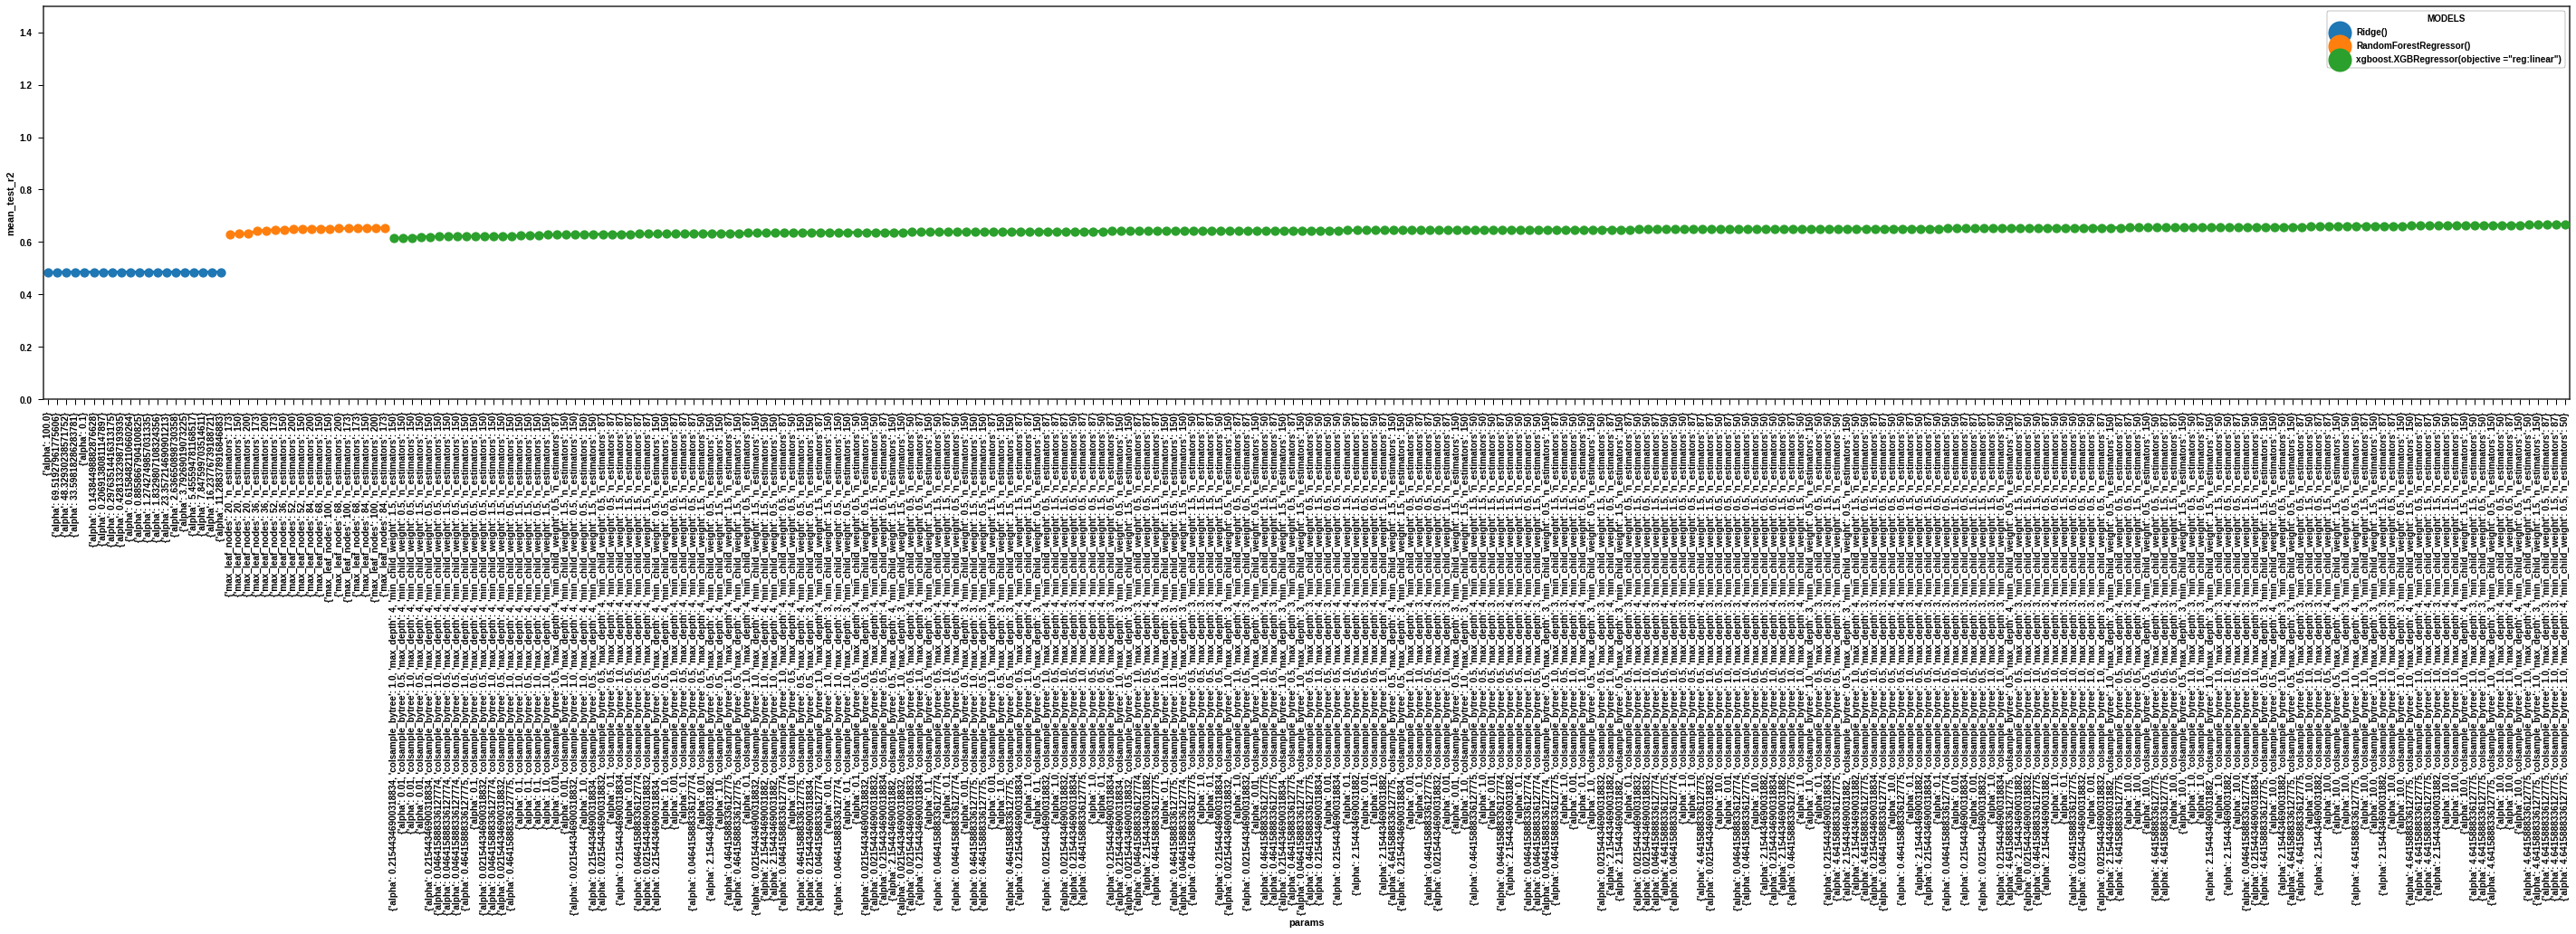

In [44]:
plt.style.use('seaborn-notebook') 
plt.rcParams["figure.figsize"] = [10*5,8]

al = dfALL_Grid.copy().reset_index()
fig, g = plt.subplots()

g = sns.pointplot(data=al, x="params", y="mean_test_r2", hue="MODELS", ci="roc_auc", capsize=.2)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylim=(0,1.5))
#ax.set(xlim=(0,2*10**6))
fig.savefig(direc0 + '34-dfALL_Grid_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

In [45]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,std_test_r2,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_fit_time,mean_score_time
MODELS,,,,,,,,
Ridge(),19,{'alpha': 100.0},0.483467,0.019393,-0.925017,0.065695,0.003808,0.002477
RandomForestRegressor(),1,"{'max_leaf_nodes': 20, 'n_estimators': 173}",0.630666,0.029595,-0.659343,0.041570,1.130447,0.049153
"xgboost.XGBRegressor(objective =""reg:linear"")",119,"{'alpha': 0.21544346900318834, 'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 150}",0.614866,0.056331,-0.686247,0.088602,1.341565,0.020773


In [46]:
c = ['mean_test_r2', 'mean_test_neg_mean_squared_error']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,mean_test_neg_mean_squared_error
MODELS,,,,
Ridge(),19,{'alpha': 100.0},0.483467,-0.925017
RandomForestRegressor(),1,"{'max_leaf_nodes': 20, 'n_estimators': 173}",0.630666,-0.659343
"xgboost.XGBRegressor(objective =""reg:linear"")",119,"{'alpha': 0.21544346900318834, 'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 150}",0.614866,-0.686247


### Bests models

In [47]:
predictions = search.best_estimator_.predict(X_train)

In [48]:
BEST_values = pd.DataFrame([np.float64(y_train)], index=['TRAIN']).T

for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_Grid[c]+'_CO2_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_train, y_train)
    predictions = search.best_estimator_.predict(X_train)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_train), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_train), np.array(predictions))
    lin_r2 = r2_score(np.array(y_train), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    print('Mean:','%0.0f'%(y_train.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_train.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
Mean: 4 / MSE: 1.24 / RMSE: 1.11 / MAE: 0.91 / r2: 0.31 / RelativeError(%): 29.7 %
RandomForestRegressor()
Mean: 4 / MSE: 0.38 / RMSE: 0.61 / MAE: 0.50 / r2: 0.79 / RelativeError(%): 16.4 %
xgboost.XGBRegressor(objective ="reg:linear")
[12:20:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 4 / MSE: 0.42 / RMSE: 0.65 / MAE: 0.51 / r2: 0.77 / RelativeError(%): 17.3 %


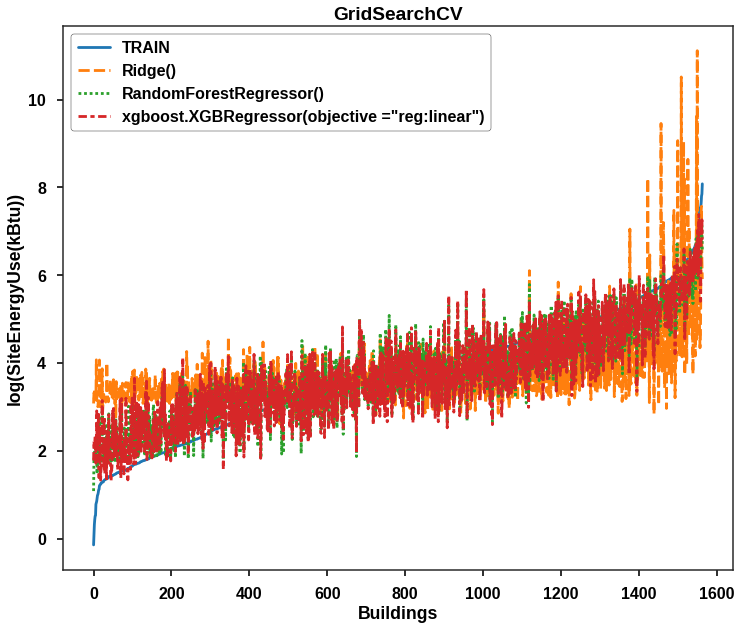

In [49]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TRAIN'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('GridSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_Grid_values_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

### Features contribution

In [50]:
search = joblib.load(dirDATA + model_names_Grid[2]+'_CO2_Multi.pkl')
final_model = search.best_estimator_
final_model

XGBRegressor(alpha=4.6415888336127775, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=4.64158869, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

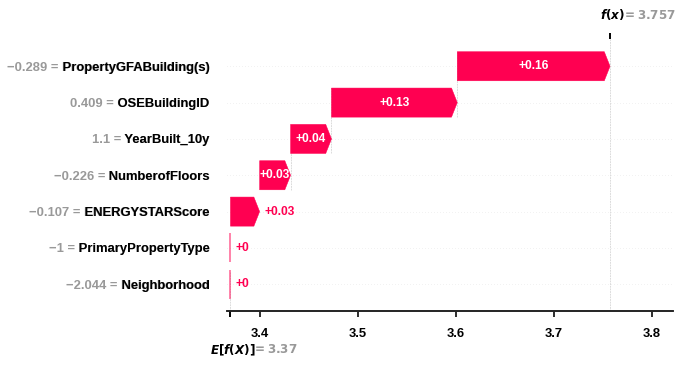

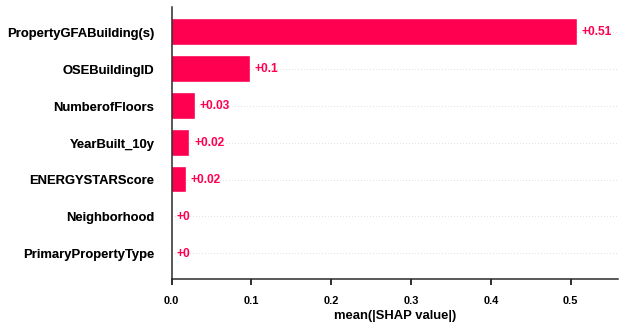

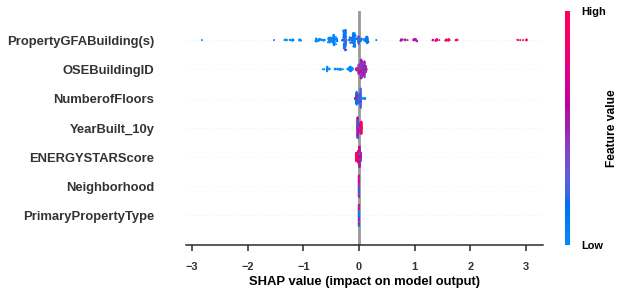

In [51]:
vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Evaluation

## Parameters

In [52]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain)
y_test = np.log(ytest)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

## Results

In [53]:
dfALL_Grid = pd.DataFrame([])
dfTOP_Grid = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL) #Parametres of model
    
    search = joblib.load(dirDATA + model_names_Grid[c]+'_CO2_Multi.pkl') #Import restulats calcule
    
    al = pd.DataFrame(search.cv_results_)
    #al['RMSE'] =  np.sqrt(-al['mean_test_score'])
    #al['std_RMSE'] =  np.sqrt(al['std_test_score'])
    al["params"] = al["params"].astype('str').convert_dtypes()
    al = al.sort_values(['rank_test_r2'], ascending = True)    #r = pd.DataFrame(search.cv_results_)

    al = pd.concat([al], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfALL_Grid = pd.concat([dfALL_Grid,al], axis = 0)

    t = al.iloc[:1]
    #tt = pd.concat([t], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfTOP_Grid = pd.concat([dfTOP_Grid,t], axis = 0)

In [54]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,std_test_r2,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_fit_time,mean_score_time
MODELS,,,,,,,,
Ridge(),13,{'alpha': 11.288378916846883},0.485813,0.022138,-0.920649,0.066152,0.005504,0.004288
RandomForestRegressor(),13,"{'max_leaf_nodes': 84, 'n_estimators': 173}",0.654044,0.035682,-0.617417,0.055034,1.715889,0.037007
"xgboost.XGBRegressor(objective =""reg:linear"")",210,"{'alpha': 4.6415888336127775, 'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 0.5, 'n_estimators': 50}",0.668262,0.037866,-0.591426,0.054040,0.452071,0.026223


## Bests models

In [55]:
BEST_values = pd.DataFrame([np.float64(y_test)], index=['TEST']).T
dfTOP_Best = pd.DataFrame([], index=dfTOP_Grid.droplevel(1,axis=0).index, columns=['params','mean_test_r2', 'mean_test_neg_mean_squared_error'])
dfTOP_Best['params'] = dfTOP_Grid['params'].droplevel(1,axis=0)
for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_Grid[c]+'_CO2_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_test, y_test)
    predictions = search.best_estimator_.predict(X_test)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_test), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_test), np.array(predictions))
    lin_r2 = r2_score(np.array(y_test), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    dfTOP_Best.loc[iMODEL, ['mean_test_r2', 'mean_test_neg_mean_squared_error']] = [lin_r2, lin_mse]
    
    #print('Mean:','%0.0f'%(y_test.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_test.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
RandomForestRegressor()
xgboost.XGBRegressor(objective ="reg:linear")
[12:20:35] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
c = ['mean_test_r2', 'mean_test_neg_mean_squared_error']

dfTOP_Best[['params']+c].style.background_gradient(subset=c)

,params,mean_test_r2,mean_test_neg_mean_squared_error
MODELS,,,
Ridge(),{'alpha': 11.288378916846883},0.361493,1.294417
RandomForestRegressor(),"{'max_leaf_nodes': 84, 'n_estimators': 173}",0.926234,0.149542
"xgboost.XGBRegressor(objective =""reg:linear"")","{'alpha': 4.6415888336127775, 'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 0.5, 'n_estimators': 50}",0.840028,0.324304


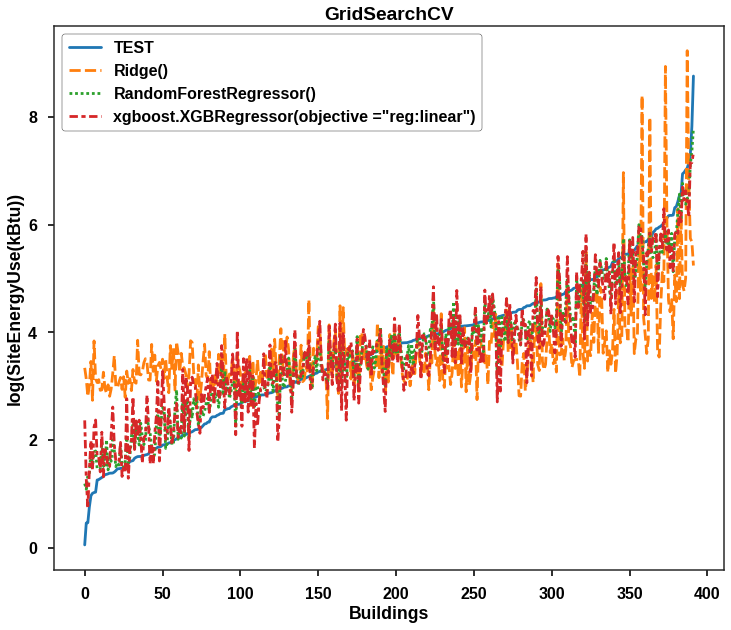

In [57]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TEST'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('GridSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_best_values_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

## Selected model : XGBRegressor

In [58]:
m = 2
t = model_names_Grid[m]
t

'XGBRegressor_Grid'

In [59]:
search = joblib.load(dirDATA + model_names_Grid[m]+'_CO2_Multi.pkl')
final_model = search.best_estimator_
final_model

XGBRegressor(alpha=4.6415888336127775, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=4.64158869, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [60]:
np.e**BEST_values.iloc[:,[0,m+1]]

,TEST,"xgboost.XGBRegressor(objective =""reg:linear"")"
0,8.21,23.808182
1,11.40,14.270785
2,44.40,63.792110
3,12.09,15.983951
4,59.14,34.850559
...,...,...
387,31.47,45.416313
388,9.99,17.177238
389,62.46,59.357868
390,18.95,7.155723


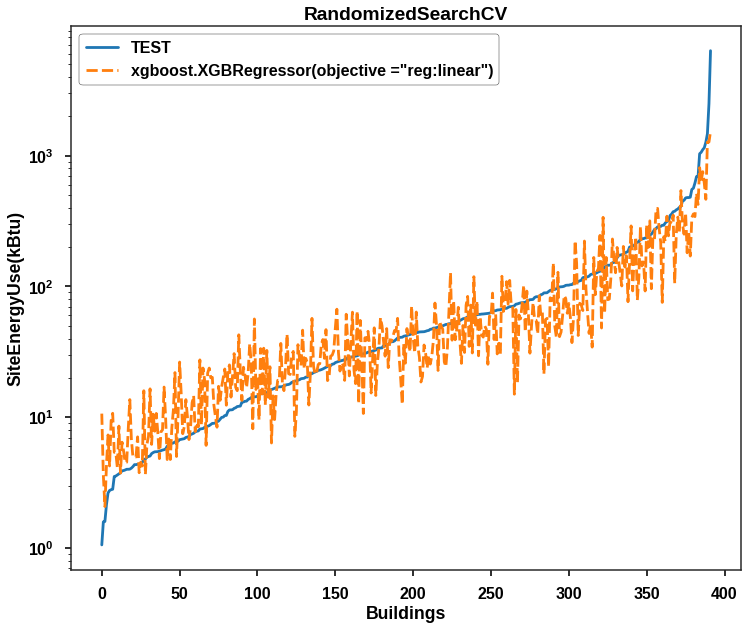

In [61]:
plt.style.use('seaborn-poster') 
BEST_values_sort = np.e**BEST_values.iloc[:,[0,m+1]].sort_values(['TEST'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('SiteEnergyUse(kBtu)')
ax.set_xlabel('Buildings')

#ax.set(ylim=(0,10**16))

ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '54-SELECTED_Modelvalues_sort_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

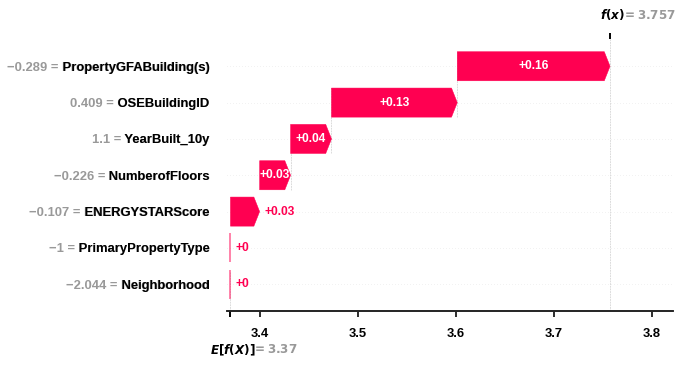

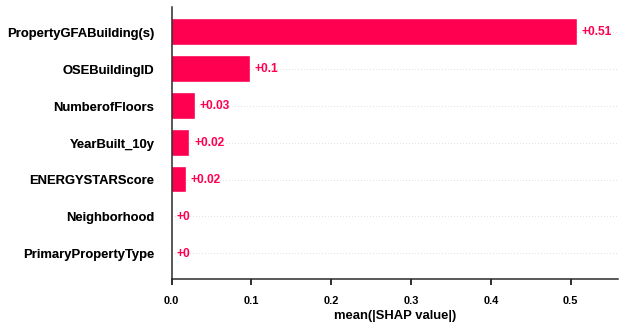

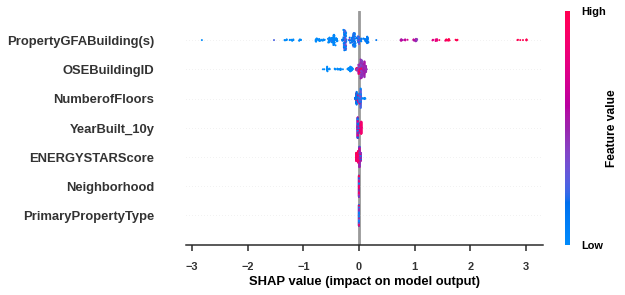

In [62]:
vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Results

In [63]:
dfRESULT = np.e**BEST_values.iloc[:,[0,m+1]]
dfRESULT.index = X_test.index
dfRESULT['RMSE'] = np.sqrt(abs(dfRESULT.iloc[:,1]**2-dfRESULT['TEST']**2))
dfRESULT['PrimaryPropertyType'] = dfML['PrimaryPropertyType'].loc[X_test.index]
dfRESULT

,TEST,"xgboost.XGBRegressor(objective =""reg:linear"")",RMSE,PrimaryPropertyType
1389,8.21,23.808182,22.347828,low-rise multifamily
1852,11.40,14.270785,8.584598,small- and mid-sized office
1037,44.40,63.792110,45.804731,low-rise multifamily
1025,12.09,15.983951,10.455553,mid-rise multifamily
1271,59.14,34.850559,47.780520,warehouse
...,...,...,...,...
21,31.47,45.416313,32.745697,k-12 school
613,9.99,17.177238,13.973454,low-rise multifamily
428,62.46,59.357868,19.439526,mid-rise multifamily
1292,18.95,7.155723,17.547026,low-rise multifamily


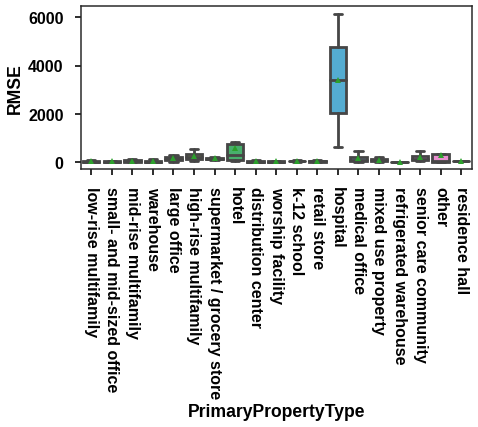

In [64]:
fig = plt.figure(figsize=(7, 3))
g = sns.boxplot(data=dfRESULT, y='RMSE', x='PrimaryPropertyType',  showfliers=False, showmeans = True) #)
g.set_xticklabels(g.get_xticklabels(), rotation=-90)
plt.show()
fig.savefig(direc0 + '6-dfRESULT_CO2_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

## RFE

In [65]:
from sklearn.feature_selection import RFE

dfRFE = pd.DataFrame([])
estimator = search.best_estimator_
c=0

for v in X_train.columns:
    c=c+1
    selector = RFE(estimator, c, step=1)
    selector = selector.fit(X_train, y_train)

    rfe_mask = selector.get_support() #list of booleans for selected features
    new_features = [] 
    for bool, feature in zip(rfe_mask, X_train.columns):
        if bool:
            new_features.append(feature)
    f  = print(new_features) # The list of your 5 best features
    
    #prediction
    dfRFE
    predictions = selector.predict(X_test)
    B_v = pd.DataFrame([predictions], index=[c]).T
    dfRFE = pd.concat([dfRFE,B_v], axis=1)
dfRFE = pd.concat([y_test.reset_index(drop=True), dfRFE], axis=1)

Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:38] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:38] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:38] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)']
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: .

Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'PrimaryPropertyType']
[12:20:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'PrimaryPropertyType', 'YearBuilt_10y']
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'PrimaryPropertyType', 'YearBuilt_10y', 'ENERGYSTARScore']
[12:20:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'NumberofFloors', 'PrimaryPropertyType', 'YearBuilt_10y', 'ENERGYSTARScore']
[12:20:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Pass n_features_to_select=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


[12:20:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'NumberofFloors', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt_10y', 'ENERGYSTARScore']
[12:20:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
['PropertyGFABuilding(s)', 'OSEBuildingID', 'NumberofFloors', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt_10y', 'ENERGYSTARScore']


Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


In [66]:
dfRFE = dfRFE.sort_values('GHGEmissions(MetricTonsCO2e)').reset_index(drop=True)
dfRFE

,GHGEmissions(MetricTonsCO2e),1,2,3,4,5,6,7
0,0.058269,3.767698,3.894934,3.972713,3.518987,3.643617,3.609056,3.627909
1,0.463734,3.158019,3.015046,2.940968,2.728661,2.928246,2.785058,3.228603
2,0.470004,1.296865,1.655316,2.247193,2.093056,1.993016,2.248026,2.188231
3,0.765468,2.724772,2.536668,2.241281,2.158379,1.851692,1.815889,2.188584
4,0.970779,3.091425,3.086998,2.869903,2.720105,2.982643,2.941649,3.062087
...,...,...,...,...,...,...,...,...
387,7.046212,6.160477,6.919734,6.751439,6.871520,6.874079,6.972406,7.230852
388,7.143057,5.699132,6.169404,6.102272,6.316979,6.125543,5.895439,6.171501
389,7.291997,5.115538,6.449342,6.236662,6.510281,6.488839,6.362240,6.506883
390,7.81995,5.631254,6.688690,6.568999,6.714026,6.622172,6.548660,6.459401


In [67]:
dfRFE.dtypes

GHGEmissions(MetricTonsCO2e)    Float64
1                               float32
2                               float32
3                               float32
4                               float32
5                               float32
6                               float32
7                               float32
dtype: object

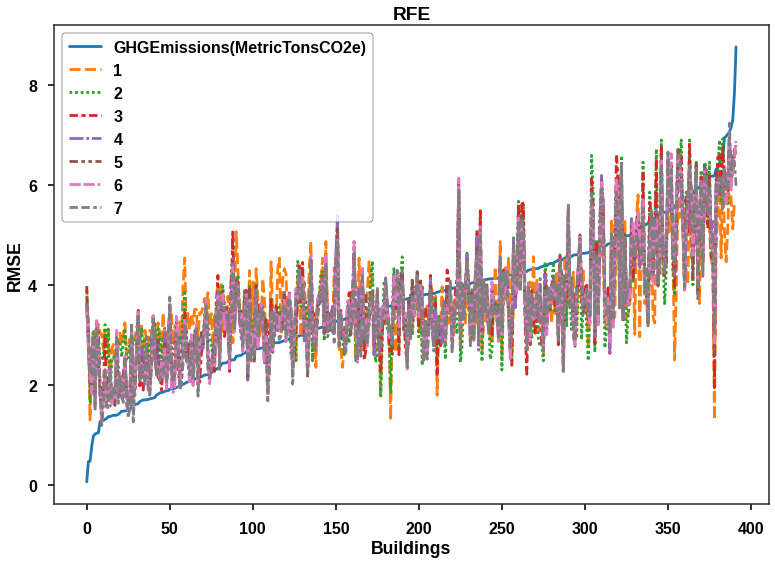

In [68]:
fig, ax = plt.subplots()

sns.lineplot(data=dfRFE)

ax.set_title('RFE')
ax.set_ylabel('RMSE')
ax.set_xlabel('Buildings')

fig.savefig(direc0 + '6-RFE_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')